In [8]:
from posteriordb import PosteriorDatabase
import os
import json
import bridgestan as bs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stein_thinning.stein import ksd
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_centkgm

from stein_pi_thinning.target import PiTargetCentKGM
from stein_pi_thinning.mcmc import mala_adapt
from stein_pi_thinning.util import flat
from stein_pi_thinning.progress_bar import disable_progress_bar

import wasserstein


np.random.seed(1234)
disable_progress_bar()

### Model Preparation

In [9]:
# Load DataBase Locally
pdb_path = os.path.join("../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("nes1984-nes")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

In [10]:
# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s

gs_matrix = np.array([df.values[0,i] for i in range(df.shape[1])]).T

### P Target and Q Target

In [11]:
# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [12]:
# Construct log-Pi-pdf and its gradient
# Using Centralised KGM kernel
# linv is -Hessian Matrix at P mode

# Stein Centralised KGM kernel
dim = model.param_num()
x_unconstrain_map = model.param_unconstrain(np.mean(gs_chains, axis=1))
linv = -hess_log_p(x_unconstrain_map)
s = 3.0

stein_q_kgm = PiTargetCentKGM(log_p, grad_log_p, hess_log_p, linv, s, x_unconstrain_map)
log_q = stein_q_kgm.log_q
grad_log_q = stein_q_kgm.grad_log_q

In [13]:
# MALA With pre-conditioning
# Parameters
nits = 100_000 # the number of iterations

alpha = 10 * [1]
epoch = 9 * [1_000] + [nits]

_, _, x_p_epoch, _, _, nacc_p = mala_adapt(log_p, grad_log_p, x_unconstrain_map, 1, np.eye(dim), alpha, epoch)
print('acc_p =', np.mean(nacc_p[-1]))

acc_p = 0.56852


In [14]:
_, _, x_q_epoch, _, _, nacc_q = mala_adapt(log_q, grad_log_q, x_unconstrain_map, 1, np.eye(dim), alpha, epoch)
print('acc_q =', np.mean(nacc_q[-1]))

acc_q = 0.5669


In [15]:
x_p_unconstrain = np.array(x_p_epoch[-1], dtype=np.float64)
grad_x_p_unconstrain = np.array([grad_log_p(i) for i in x_p_unconstrain])

x_q_unconstrain = np.array(x_q_epoch[-1], dtype=np.float64)
grad_x_q_unconstrain = np.array([grad_log_p(i) for i in x_q_unconstrain])

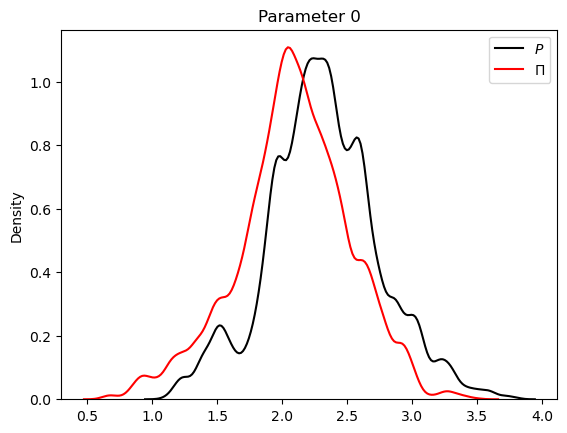

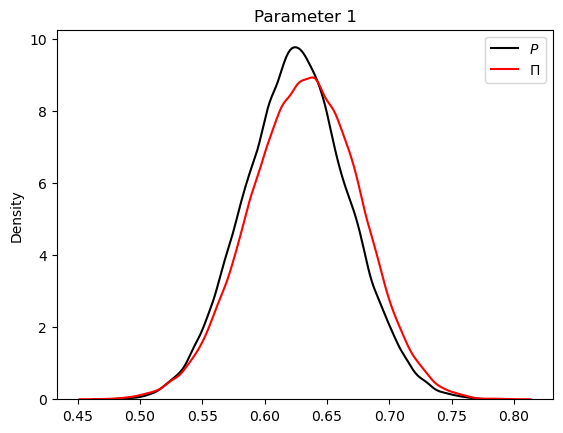

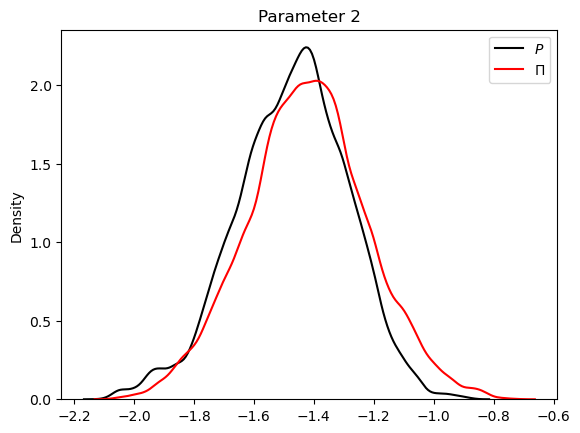

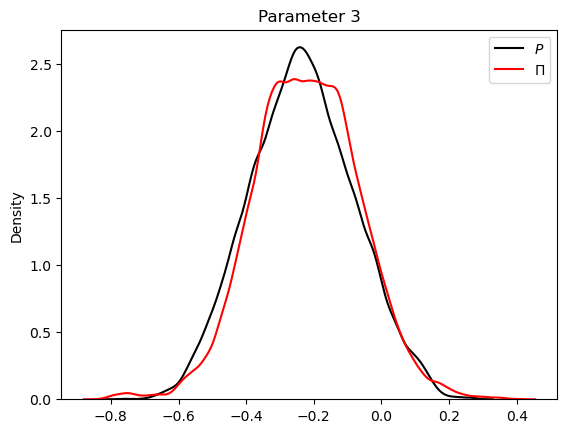

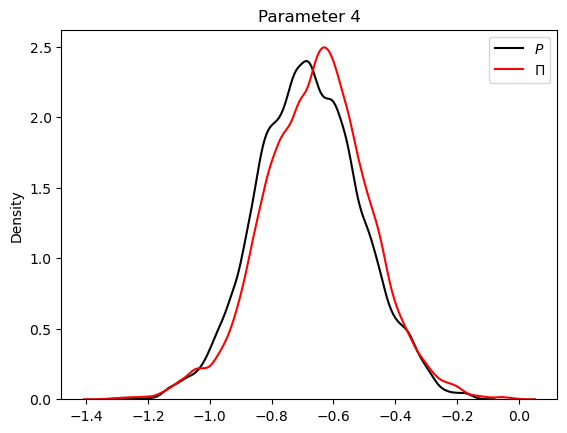

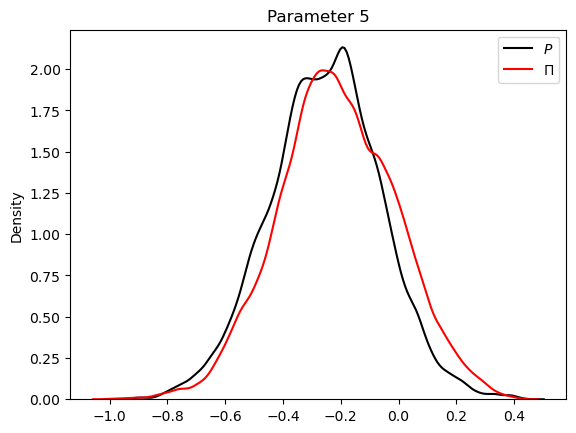

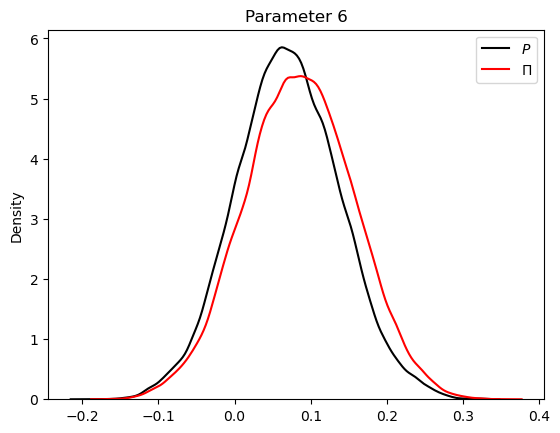

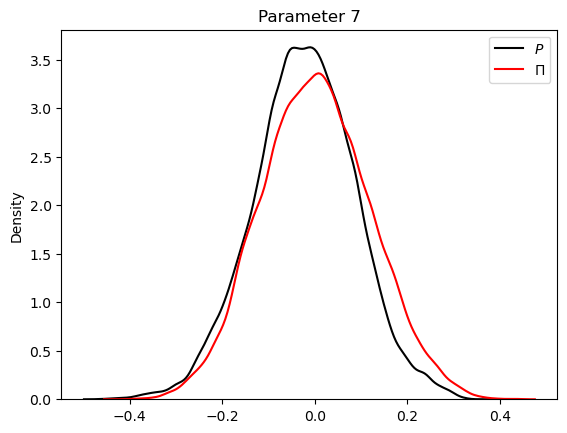

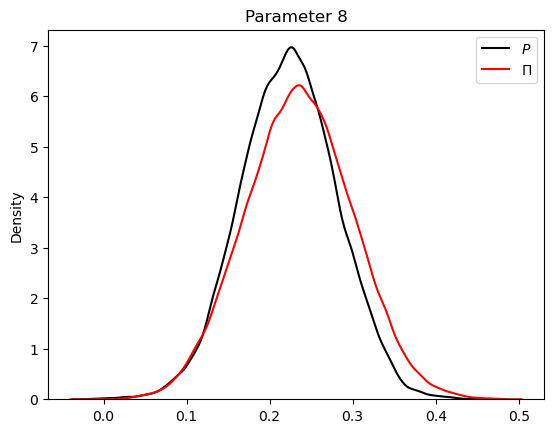

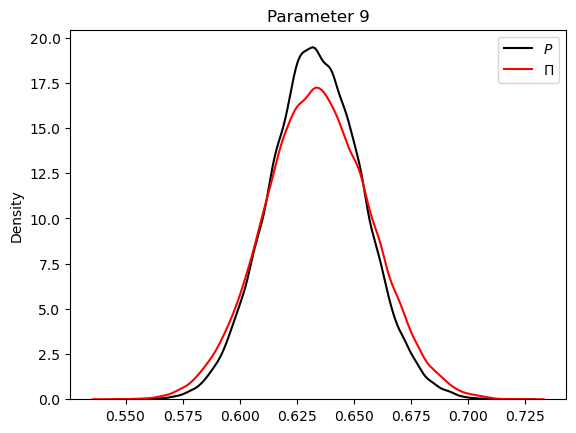

In [16]:
for i in range(dim):
    # plt.hist(x_p_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='p')
    # plt.hist(x_q_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='q')
    sns.kdeplot(x_p_unconstrain[:,i].flatten(), label='$P$', color="black")
    sns.kdeplot(x_q_unconstrain[:,i].flatten(), label='$\Pi$', color="red")

    plt.title(f"Parameter {i}")
    plt.legend()
    plt.show()

### Thinning

In [17]:
fixed_ratio = 0.1
iteration_list = [10, 20, 50, 100, 200, 500, 1000, 2000]

#IMQ
vfk0_imq = make_imq(x_p_unconstrain, grad_x_p_unconstrain, pre=linv)

res_ksd_p_imq = []
res_ksd_q_imq = []
res_ksd_p_thinning_imq = []
res_ksd_q_thinning_imq = []

In [18]:
# IMQ Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_imq)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_imq)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_imq)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_imq)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_imq.append(ks_p[-1])
    res_ksd_q_imq.append(ks_q[-1])

    res_ksd_p_thinning_imq.append(ks_p_thinning[-1])
    res_ksd_q_thinning_imq.append(ks_q_thinning[-1])

10 188.85642556725213
10 168.03685901689866
20 100.87930507824215
20 150.40331955092435
50 66.92630240146426
50 72.87769315665645
100 45.65671406363303
100 62.80640809360428
200 33.93264424285876
200 47.28565442641795
500 22.163808395235847
500 33.644130776803706
1000 14.33823757339095
1000 43.031198435762796
2000 9.928485284377395
2000 22.140612797709004


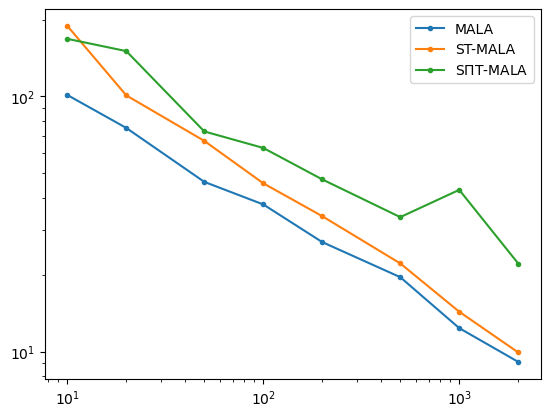

In [19]:
plt.loglog(iteration_list, res_ksd_p_imq, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_imq, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [20]:
#KGM
vfk0_centkgm = make_centkgm(x_p_unconstrain, grad_x_p_unconstrain, x_map=x_unconstrain_map, pre=linv, s=s)

res_ksd_p_centkgm = []
res_ksd_q_centkgm = []
res_ksd_p_thinning_centkgm = []
res_ksd_q_thinning_centkgm = []

In [21]:
# KGM Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    # print(f"No.{i} Index Calculation Begin")

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_centkgm)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_centkgm)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_centkgm)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_centkgm)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_centkgm.append(ks_p[-1])
    res_ksd_q_centkgm.append(ks_q[-1])

    res_ksd_p_thinning_centkgm.append(ks_p_thinning[-1])
    res_ksd_q_thinning_centkgm.append(ks_q_thinning[-1])

10 2338.043853663573
10 1760.9653440899617
20 1365.0635697594103
20 1549.5702647835453
50 946.4271208070504
50 761.7017507069494
100 521.339231826665
100 888.974927064749
200 324.913909536894
200 912.9553562949926
500 200.87350042213205
500 578.8758790694762
1000 93.43129574239381
1000 993.9773492168673
2000 69.91267495307075
2000 530.350527378622


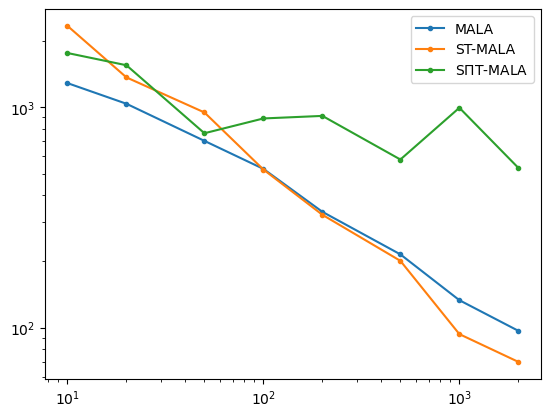

In [22]:
plt.loglog(iteration_list, res_ksd_p_centkgm, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_centkgm, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

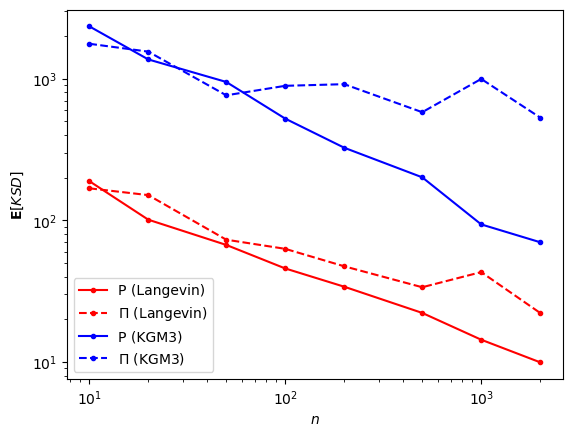

In [23]:
plt.loglog(iteration_list, res_ksd_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$KSD$]')
plt.legend()

### WasserStein

In [24]:
gs = np.zeros_like(gs_chains.T)
# gs = np.zeros_like(gs_matrix)

for i in range(gs_chains.T.shape[0]):
    gs[i] = model.param_unconstrain(gs_chains.T[i].astype(np.float64))
# for i in range(gs_matrix.shape[0]):
#     gs[i] = model.param_unconstrain(gs_matrix[i].astype(np.float64))
emd = wasserstein.EMD(n_iter_max=1_000_000)
gs_weights = np.repeat(1/gs.shape[0], gs.shape[0])

In [25]:
#IMQ
res_wass_p_imq = []
res_wass_q_imq = []
res_wass_p_thinning_imq = []
res_wass_q_thinning_imq = []

In [26]:
# IMQ Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_imq.append(wass_p)
    res_wass_q_imq.append(wass_q)

    res_wass_p_thinning_imq.append(wass_p_thinning)
    res_wass_q_thinning_imq.append(wass_q_thinning)

10 0.8408257504500845
10 1.0620921628159983
20 0.845924896667212
20 1.0397067948679029
50 0.8591563486405291
50 1.0075223193169478
100 0.7636698737715519
100 0.9767644163905208
200 0.7683991314975389
200 0.9740034271042817
500 0.6107435571212565
500 0.8746961013075452
1000 0.5193311610497668
1000 0.6611271847061087
2000 0.5532575080473322
2000 0.5115849675926748


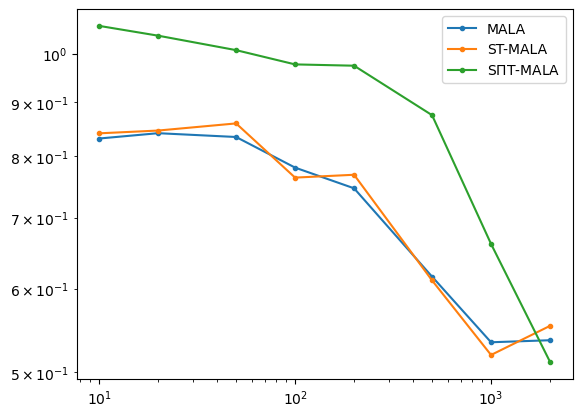

In [27]:
plt.loglog(iteration_list, res_wass_p_imq, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [28]:
#KGM
res_wass_p_centkgm = []
res_wass_q_centkgm = []
res_wass_p_thinning_centkgm = []
res_wass_q_thinning_centkgm = []

In [29]:
# KGM Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=linv,\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_centkgm.append(wass_p)
    res_wass_q_centkgm.append(wass_q)

    res_wass_p_thinning_centkgm.append(wass_p_thinning)
    res_wass_q_thinning_centkgm.append(wass_q_thinning)

10 0.8236814778759625
10 1.1001953981605066
20 0.845924896667212
20 1.0397067948679029
50 0.8293356350285491
50 1.0185278961656934
100 0.7412248372499884
100 0.986111553601593
200 0.7341626079084825
200 0.9545690065090837
500 0.5885643399609045
500 0.8700481771789895
1000 0.50883067844032
1000 0.6641151000925031
2000 0.5196053133201014
2000 0.5403731156856203


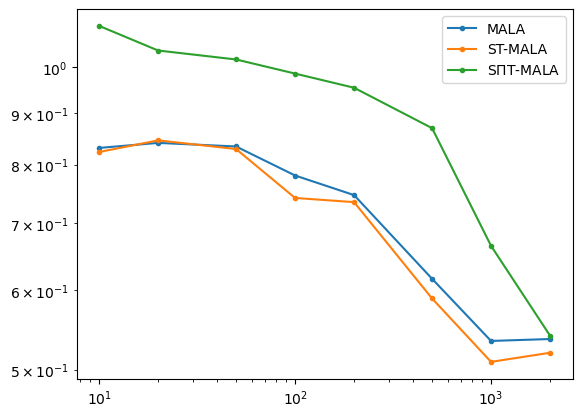

In [30]:
plt.loglog(iteration_list, res_wass_p_centkgm, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

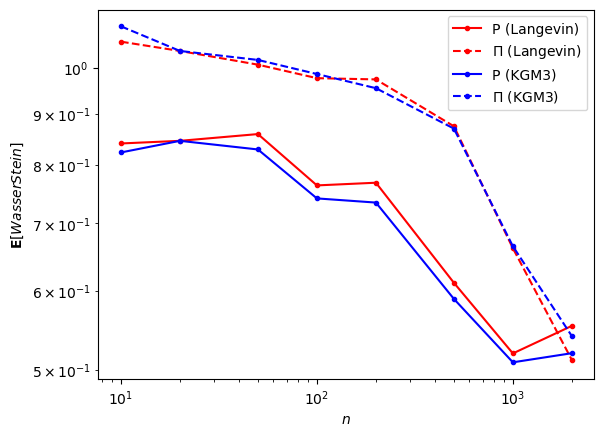

In [31]:
plt.loglog(iteration_list, res_wass_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_wass_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_wass_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$WasserStein$]')
plt.legend()